In [28]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from google.colab import drive
drive.mount('/content/drive')

DATA_PATH = "/content/drive/MyDrive/data/"

SEED = 42 # 시드값

# 데이터 블러오기
train = pd.read_csv(f"{DATA_PATH}titanic_train.csv") # 학습데이터
test = pd.read_csv(f"{DATA_PATH}titanic_test.csv") # 테스트 데이터

# 결측치 처리
age_mean = train["age"].mean()
fare_median = train["fare"].median()
cabin_unk = "UNK"
embarked_mode = train["embarked"].mode()[0]
train["age"] = train["age"].fillna(age_mean)
train["cabin"] = train["cabin"].fillna(cabin_unk)
test["age"] = test["age"].fillna(age_mean)
test["fare"] = test["fare"].fillna(fare_median)
test["cabin"] = test["cabin"].fillna(cabin_unk)
test["embarked"] = test["embarked"].fillna(embarked_mode)

# 특성으로 사용할 변수 선택
cols = ["age","sibsp","parch","fare","pclass","gender","embarked"]
train_ft = train[cols].copy()
test_ft = test[cols].copy()

# 범주형 변수 원핫인코딩
cols = ['gender','embarked']
enc = OneHotEncoder(handle_unknown = 'ignore')
enc.fit(train[cols])
tmp = pd.DataFrame(
    enc.transform(train_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
train_ft = pd.concat([train_ft,tmp],axis=1).drop(columns=cols)
tmp = pd.DataFrame(
    enc.transform(test_ft[cols]).toarray(),
    columns = enc.get_feature_names_out()
)
test_ft = pd.concat([test_ft,tmp],axis=1).drop(columns=cols)

# Min-Max Scaling
scaler = MinMaxScaler()
scaler.fit(train_ft)
train_ft[train_ft.columns] = scaler.transform(train_ft)
test_ft[test_ft.columns] = scaler.transform(test_ft)

# 정답 데이터
target = train["survived"]

train_ft.shape, test_ft.shape, target.shape

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


((916, 10), (393, 10), (916,))

# 비지도학습(Unsupervised Learning)
- 학습의 일종으로 지도학습과는 달리 입력값에 대한 목표치(target)가 주어지지 않고 데이터의 상관관계와 패턴을 학습하는 방식
- 차원축소
    - 다차원의 데이터를 더 작은 차원으로 변환하여 중요한 정보만을 남기고 분석하기 쉽게 만드는 과정
- 군집분석
    - 군집 분석은 데이터 내에서 유사한 속성을 가진 데이터들을 그룹으로 묶어 군집을 형성하는 과정





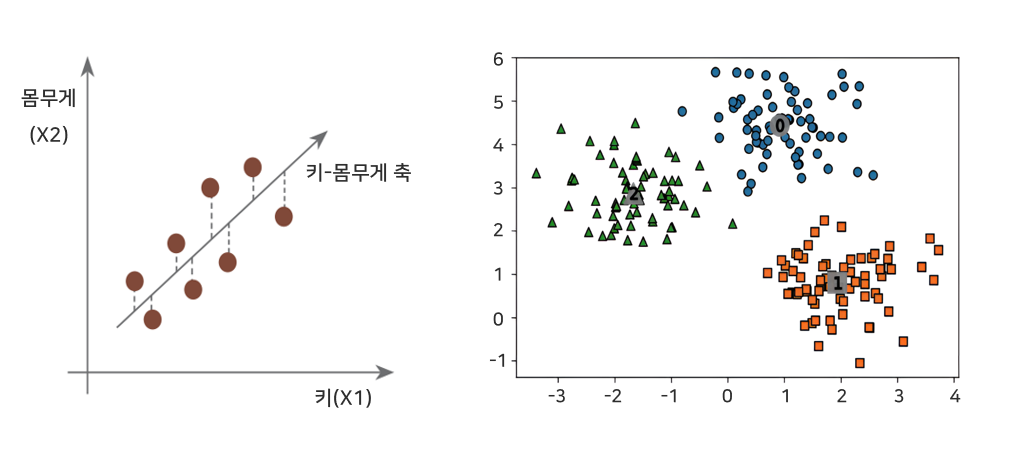

## 지도학습과 비지도학습 비교
- X는 Y를 설명할 수 있는 데이터
- X를 설명할 수 있는 Z가 존재한다고 가정


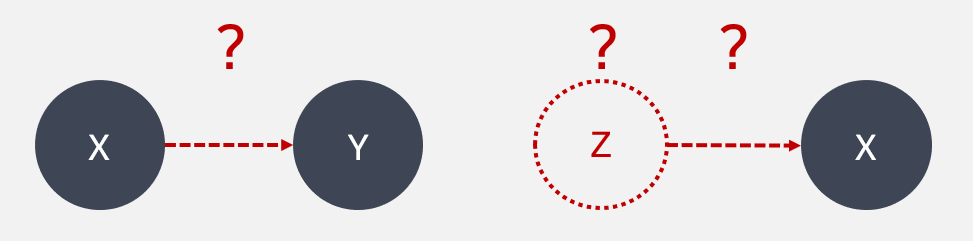

## 비지도학습 활용 사례
- 차원축소를 활용한 시스템 보안 위협 탐지
    - 1,090,448건 중 보안 위협 885건
    - 재구성 오차가 임계치를 초과하는 샘플 추출





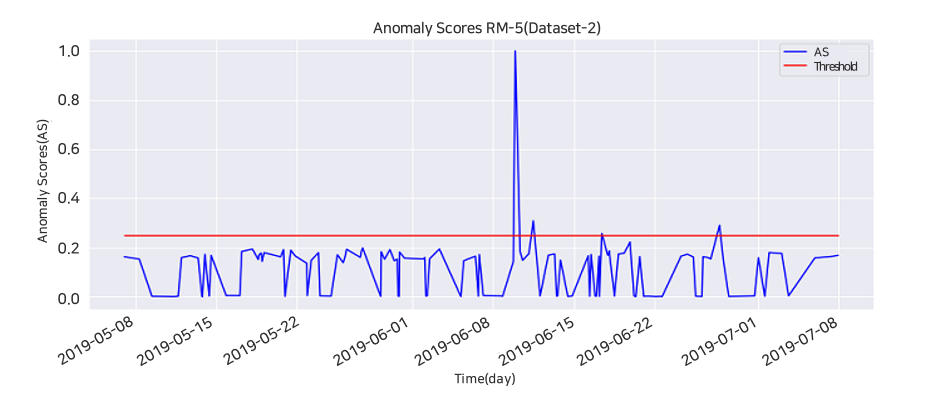

- 싱가포르의 코로나19 사례에 대한 군집분석



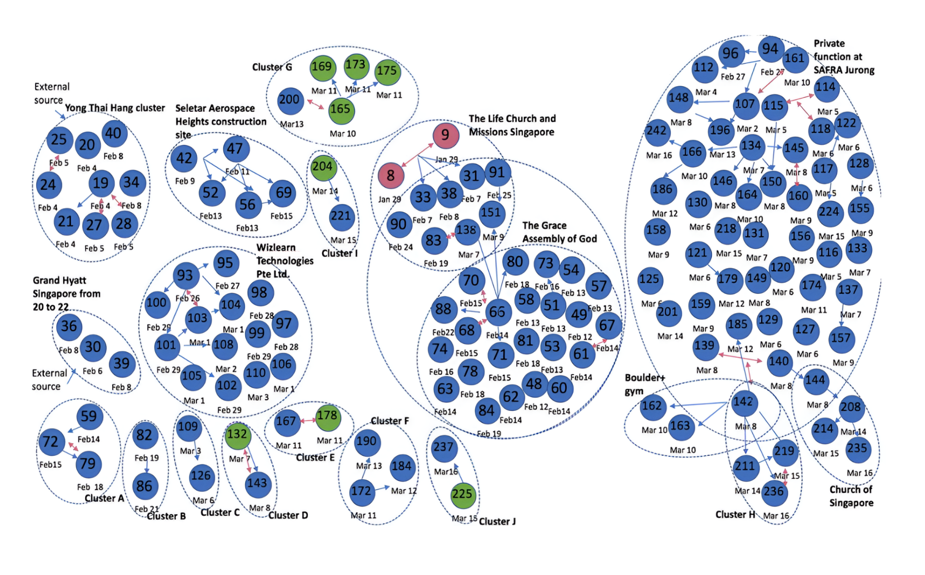

# 차원축소(Dimension Reduction)
- 매우 많은 피처로 구성된 데이터를 피처의 차원을 축소해 새로운 데이터를 생성하는 것​
- 차원의 저주를 해결하기 위해 차원 축소기법을 사용
- 차원의 저주
    - 데이터 학습을 위해 차원이 증가하면서 학습데이터 수가 차원의 수보다 적어져 성능이 저하되는 현상
- 수백 개 이상의 피처로 학습된 모델은 상대적으로 적은 피처에서 학습된 모델보다 예측 신뢰도가 낮을 수도 있음
- 피처가 많을 수록 개별 피처간 상관관계가 높을 가능성이 커져 다중 공선성 문제가 발생하여 모델의 예측 성능이 저하될 수 있음





In [29]:
cols = ["ticket", "cabin"]

enc = OneHotEncoder(handle_unknown="ignore")
enc.fit(train[cols])

OneHotEncoder(handle_unknown='ignore')

In [30]:
sparse_train = pd.DataFrame(enc.transform(train[cols]).toarray(), columns=enc.get_feature_names_out())
sparse_test = pd.DataFrame(enc.transform(test[cols]).toarray(), columns=enc.get_feature_names_out())
sparse_train.shape, sparse_test.shape

((916, 838), (393, 838))

- 차원 축소 전 cv 점수 확인

In [31]:
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold, cross_val_score

cv = KFold(5, shuffle=True, random_state=SEED)
model = LGBMClassifier(random_state=SEED)
x = pd.concat([train_ft, sparse_train], axis=1)
scores = cross_val_score(model, x, target, cv=cv, scoring="roc_auc", n_jobs=-1)
scores.mean()

0.896859493098043

## PCA(Principal Component Analysis)
- 가장 대표적인 차원축소 기법으로 주성분 분석이라고 함
- 여러 변수 간에 존재하는 상관관계를 이용해 이를 대표하는 주성분을 추출해 차원을 축소하는 기법​
- 새로 파생된 특성을 주성분이라고 함
1. 가장 큰 변동성을 기반으로 첫번째 벡터 축을 생성
2. 두번째 축은 첫번째 축과 직교하면서 분산이 최대인 축을 생성
3. 주성분 개수만큼 반복하여 축을 생성
4. 생성된 축으로 데이터를 투영함



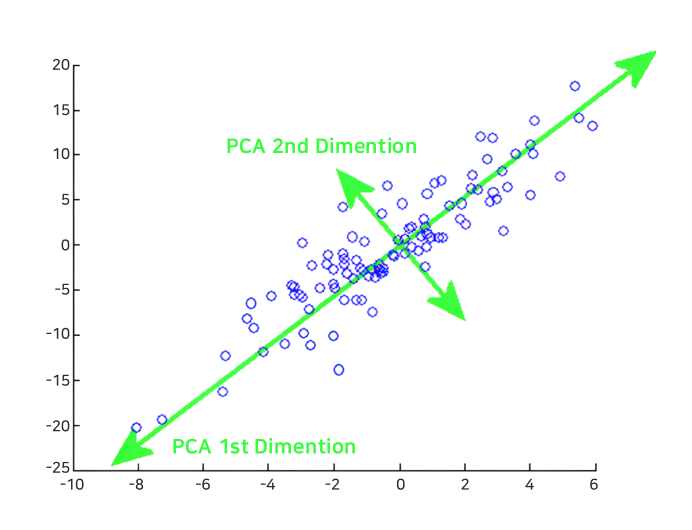

- PCA 클래스주요 파라미터
    - random_state
        - 시드값
    - n_components
        - 주성분 수


In [32]:
sparse_train.shape

(916, 838)

In [33]:
from sklearn.decomposition import PCA

pca = PCA(100, random_state=SEED)
pca.fit(sparse_train)

tmp = pd.DataFrame(pca.transform(sparse_train)).add_prefix('pca_')
x = pd.concat([train_ft, tmp], axis=1)

scores = cross_val_score(model, x, target, cv=cv, scoring="roc_auc", n_jobs=-1)
scores.mean()

0.9058879845674982

In [34]:
tmp.head()

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,...,pca_90,pca_91,pca_92,pca_93,pca_94,pca_95,pca_96,pca_97,pca_98,pca_99
0,0.230624,-0.011140,-0.000748,-0.008181,-0.001186,0.000020,-0.000003,0.000016,-0.000017,0.000002,...,0.000985,0.001047,0.001882,0.003834,-0.000289,0.001149,-0.000186,0.000119,-0.001225,0.002167
1,0.230624,-0.011139,-0.000758,-0.008162,-0.001224,-0.000006,-0.000040,0.000050,-0.000013,0.000031,...,-0.002925,-0.002922,0.004484,-0.001903,-0.001205,-0.005517,-0.000996,0.000246,-0.000366,-0.000163
2,0.230624,-0.011139,-0.000741,-0.008212,-0.001211,0.000025,0.000017,0.000048,0.000041,-0.000049,...,0.001008,0.002819,-0.002708,-0.002540,-0.002361,-0.003645,-0.002236,0.002754,0.004076,-0.001013
3,0.230624,-0.011140,-0.000760,-0.008187,-0.001222,0.000038,0.000013,-0.000001,-0.000004,-0.000004,...,-0.000198,0.001326,-0.004334,-0.001953,0.000964,-0.002273,-0.001849,0.004351,-0.000660,0.003598
4,-0.770358,0.000670,-0.019148,0.001116,-0.003970,-0.001318,0.000609,-0.000797,0.000077,0.000891,...,0.199073,-0.096286,0.111730,0.092494,-0.090150,-0.142636,-0.047002,-0.078210,0.053625,-0.084704


In [35]:
pca.explained_variance_ratio_.sum()

0.4281872329950168

In [36]:
pca = PCA(sparse_train.shape[1], random_state=SEED)
pca.fit(sparse_train)

PCA(n_components=838, random_state=42)

In [37]:
n_arr = np.arange(200, 701, 50)
for n in n_arr:
    v = sum(pca.explained_variance_ratio_[:n])
    print(f"{n}개 주성분: {v}")

200개 주성분: 0.5867269237601561
250개 주성분: 0.6383326127363381
300개 주성분: 0.6772240207921237
350개 주성분: 0.7161154288479094
400개 주성분: 0.755006836903695
450개 주성분: 0.7938982449594806
500개 주성분: 0.8327896530152662
550개 주성분: 0.8716810610710518
600개 주성분: 0.9105724691268374
650개 주성분: 0.949463877182623
700개 주성분: 0.9883552852384087


In [38]:
pca = PCA(350, random_state=SEED)
pca.fit(sparse_train)

tmp = pd.DataFrame(pca.transform(sparse_train)).add_prefix('pca_')
x = pd.concat([train_ft, tmp], axis=1)
scores = cross_val_score(model, x, target, cv=cv, scoring="roc_auc", n_jobs=-1)
scores.mean()

0.9047312208976125

In [39]:
def get_score(decomp, sparse_train, train_ft, target, seed):
    tmp = pd.DataFrame(decomp.transform(sparse_train)).add_prefix('decomp_')
    print(f"{tmp.shape[1]}개의 차원으로 축소됨")

    x = pd.concat([train_ft, tmp], axis=1)
    model = LGBMClassifier(random_state=seed)
    cv = KFold(5, shuffle=True, random_state=seed)

    scores = cross_val_score(model, x, target, cv=cv, scoring="roc_auc", n_jobs=-1)
    return scores.mean()

In [40]:
pca = PCA(200, random_state=SEED)
pca.fit(sparse_train)
get_score(pca, sparse_train, train_ft, target, SEED)

200개의 차원으로 축소됨


0.9063344466405241

## KernelPCA 클래스
- 비선형 결합방식
- kernel을 이용하여 비선형으로 결합
- 주요 파라미터
    - random_state
        - 시드값
    - n_components
        - 주성분 수
    - kernel
        - 비선형 결합방식
        - 'linear'(기본값으로 PCA), 'poly', 'rbf', 'sigmoid', 'cosine'

In [41]:
from sklearn.decomposition import KernelPCA

decomp = KernelPCA(100, random_state=SEED, kernel='rbf')
decomp.fit(sparse_train)
get_score(decomp, sparse_train, train_ft, target, SEED)

100개의 차원으로 축소됨


0.9077569755476285

## SVD(Singular Value Decomposition)
- 행렬 분해의 종류 중 하나로 특이값 분해라고 함
- 행렬 분해
    - 하나의 행렬을 여러 개의 곱 형태로 나타내는 것
- 𝑈와 𝑉^𝑇에 속한 벡터를 특이벡터
- Σ는 대각행렬(대각에 위치한 값이 특이값)
- 특이값은 클수록 더 많은 정보를 갖고 있다고 해석함
- Truncated SVD
    - 특이값 중 상위 K개만 추출하여 대응하는 𝑈와 𝑉^𝑇로 분해해서 차원을 줄인 방식






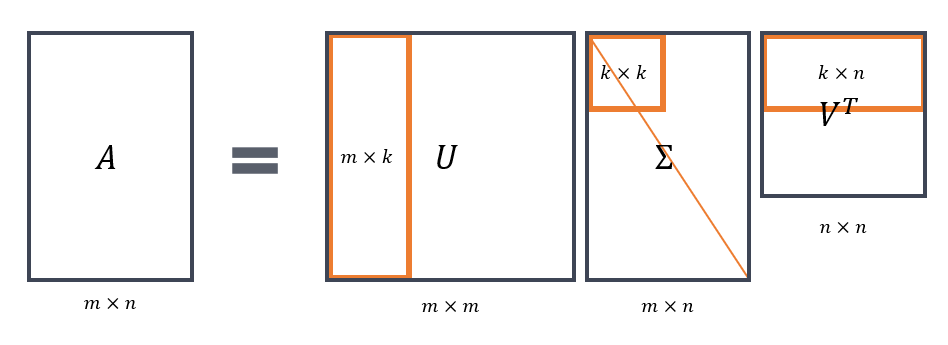

- TruncatedSVD 클래스 주요 파라미터
    - random_state
        - 시드값
    - n_components
        - 특이값 수

In [42]:
from sklearn.decomposition import TruncatedSVD

decomp = TruncatedSVD(200, random_state=SEED)
decomp.fit(sparse_train)
get_score(decomp, sparse_train, train_ft, target, SEED)

200개의 차원으로 축소됨


0.9076684487948521

## Random Projection
- 데이터포인트 간에 거리는 유지되도록 하면서
피처의 차원을 저차원으로 투영하는 기법
- 원래의 데이터가 𝑚×𝑛 행렬일 때,
무작위로 랜덤한 n×𝑘 형태의 행렬을 곱해서 𝑚×𝑘 행렬로 변환



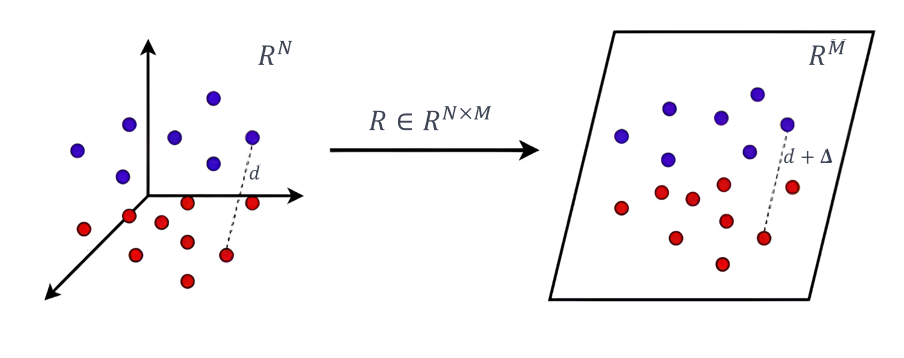

### GaussianRandomProjection 클래스
- 가우시안 분포의 랜덤한 행렬을 투영해서 데이터 포인트 간에 거리는 유지되도록 하면서 피처의 차원을 저차원으로 축소하는 기법
- 주요 파라미터
    - random_state
        - 시드값
    - n_components
        - 투영 결과의 차원수( 'auto' or int )
        - 기본값은 'auto'
    - eps
        - 입실론 값으로 n_components가 'auto'인 경우만 영향
        - 값이 작을 수록 차원이 높아짐
        - 기본값은 0.1



In [43]:
from sklearn.random_projection import GaussianRandomProjection

decomp = GaussianRandomProjection(200, random_state=42)
decomp.fit(sparse_train)
get_score(decomp, sparse_train, train_ft, target, SEED)

200개의 차원으로 축소됨


0.9134006682362303

### SparseRandomProjection 클래스
- 희소한 분포의 랜덤한 행렬을 투영해서 데이터 포인트 간에 거리는 유지되도록 하면서 피처의 차원을 저차원으로 축소하는 기법
- 주요 파라미터
    - random_state
        - 시드값
    - n_components
        - 투영 결과의 차원수( 'auto' or int )
        - 기본값은 'auto'
    - eps
        - 입실론 값으로 n_components가 'auto'인 경우만 영향
        - 값이 작을 수록 차원이 높아짐
        - 기본값은 0.1


In [44]:
from sklearn.random_projection import SparseRandomProjection

decomp = SparseRandomProjection(100, random_state=42)
decomp.fit(sparse_train)
get_score(decomp, sparse_train, train_ft, target, SEED)

100개의 차원으로 축소됨


0.9124235993131729

- test 데이터 예측

In [45]:
tmp = pd.DataFrame(decomp.transform(sparse_train)).add_prefix("sr_")
train_ft = pd.concat([train_ft, tmp], axis=1)

tmp = pd.DataFrame(decomp.transform(sparse_test)).add_prefix("sr_")
test_ft = pd.concat([test_ft, tmp], axis=1)

train_ft.shape, test_ft.shape

((916, 110), (393, 110))

In [46]:
model = LGBMClassifier(random_state=SEED)
model.fit(train_ft, target)
pred = model.predict_proba(test_ft)[:, 1]
pred.shape

[LightGBM] [Info] Number of positive: 346, number of negative: 570
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000857 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 454
[LightGBM] [Info] Number of data points in the train set: 916, number of used features: 78
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.377729 -> initscore=-0.499198
[LightGBM] [Info] Start training from score -0.499198


(393,)

In [47]:
pd.DataFrame(pred, columns=['target']).to_csv('권지혁.csv')